<a href="https://colab.research.google.com/github/ikoghoemmanuell/Bizstech-Msc.-Cybersecurity-/blob/main/liar_datasetipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News Detection with Hugging Face

Hugging Face is an open-source and platform provider of machine learning technologies. You can use install their package to access some interesting pre-built models to use them directly or to fine-tune (retrain it on your dataset leveraging the prior knowledge coming with the first training), then host your trained models on the platform, so that you may use them later on other devices and apps.

Please, [go to the website and sign-in](https://huggingface.co/) to access all the features of the platform.

[Read more about Text classification with Hugging Face](https://huggingface.co/tasks/text-classification)

The Hugging face models are Deep Learning based, so will need a lot of computational GPU power to train them. Please use [Colab](https://colab.research.google.com/) to do it, or your other GPU cloud provider, or a local machine having NVIDIA GPU.

Find below a simple example, with just 10 epochs of fine-tuning`.

Read more about the fine-tuning concept : [here](https://deeplizard.com/learn/video/5T-iXNNiwIs#:~:text=Fine%2Dtuning%20is%20a%20way,perform%20a%20second%20similar%20task.)

# Installation

In [ ]:
# !pip install zipfile
# !pip install deeplake

!pip install transformers
!pip install datasets
!pip install --upgrade accelerate
!pip install sentencepiece

## Importing Libraries

In [ ]:
import huggingface_hub # Importing the huggingface_hub library for model sharing and versioning
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import transformers
from datasets import load_dataset
from datasets import concatenate_datasets, DatasetDict
from sklearn.model_selection import train_test_split
import os

from datasets import DatasetDict, Dataset
from sklearn.metrics import mean_squared_error, classification_report

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from transformers import TrainingArguments, Trainer
from google.colab import drive
from datasets import load_dataset
import zipfile
import torch

## Load Dataset

In [ ]:
# load dataset from huggingface as a pytorch dataset
dataset = load_dataset("liar")

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 10269
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1283
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context'],
        num_rows: 1284
    })
})

In [ ]:
print(f"train_length: {len(dataset['train'])}, test_length: {len(dataset['test'])}, validation_length: {len(dataset['validation'])}")

train_length: 10269, test_length: 1283, validation_length: 1284


In [ ]:
# Join train and test datasets
combined_train_test = concatenate_datasets([dataset['train'], dataset['test']])

# Create the modified DatasetDict
modified_dataset = DatasetDict({
    'train': combined_train_test,
    'validation': dataset['validation']
})

dataset = modified_dataset

In [ ]:
print(f"train_length: {len(dataset['train'])}, validation_length: {len(dataset['validation'])}")

train_length: 11552, validation_length: 1284


In [ ]:
def convert_dataset_to_dataframe(dataset, split):
  """Converts a dataset to a DataFrame."""
  df = pd.DataFrame(dataset[split])
  df.columns = ['id', 'label', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']
  return df

train = convert_dataset_to_dataframe(dataset, 'train')

In [ ]:
# get the first 5 rows of the train set to make sure it looks right
train.head()

,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context
0,2635.json,0,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,1,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,2,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,0,Health care reform legislation is likely to ma...,health-care,blog-posting,,,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,1,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


In [ ]:
# check datatypes of the train set, object can mean text or string
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11552 entries, 0 to 11551
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    11552 non-null  object 
 1   label                 11552 non-null  int64  
 2   statement             11552 non-null  object 
 3   subject               11552 non-null  object 
 4   speaker               11552 non-null  object 
 5   job_title             11552 non-null  object 
 6   state_info            11552 non-null  object 
 7   party_affiliation     11552 non-null  object 
 8   barely_true_counts    11552 non-null  float64
 9   false_counts          11552 non-null  float64
 10  half_true_counts      11552 non-null  float64
 11  mostly_true_counts    11552 non-null  float64
 12  pants_on_fire_counts  11552 non-null  float64
 13  context               11552 non-null  object 
dtypes: float64(5), int64(1), object(8)
memory usage: 1.2+ MB


In [ ]:
train.label.unique()

array([0, 1, 2, 3, 4, 5])

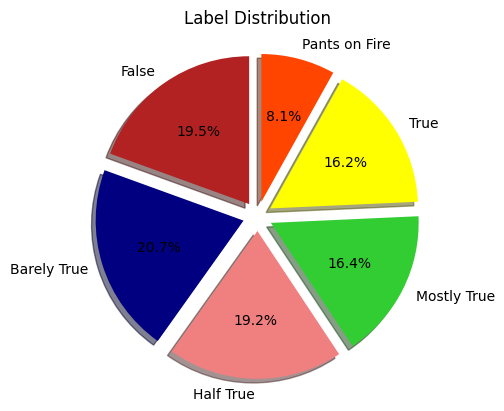

In [ ]:
# 90 true, 10 fake, 70, 30
# 40, 60 good, 55, 45 is good

# Checking if our train is well balanced
def plot_label_distribution(dataset):
  """Plots the distribution of the labels in the label column."""
  label_size = []
  for label in range(6):
    label_size.append(len(dataset[dataset['label'] == label]))

  plt.pie(label_size,explode=[0.1,0.1,0.1,0.1,0.1,0.1],colors=['firebrick','navy','lightcoral','limegreen','yellow','orangered'],startangle=90,shadow=True,labels=['False','Barely True','Half True','Mostly True','True','Pants on Fire'],autopct='%1.1f%%')
  plt.title('Label Distribution')
  plt.show()

train_df = convert_dataset_to_dataframe(dataset, 'train')
plot_label_distribution(train_df)

## Preprocessing and tokenization

In [ ]:
# define helper functions

# funtion to replace usernames and links with placeholders.
def preprocess(text):
  # "@user my name is john"
  # "http my name is john"
    new_text = []
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# no need for encoding: Fake=1, True=0 bcuz the target variable called label is already encoded

In [ ]:
# Define the apply_preprocess function
def apply_preprocess(dataset, column='statement'):
    return dataset.map(lambda example: {column: preprocess(example[column])},
                       remove_columns=[column])

# Apply the preprocess function to the 'statement' column in both 'train' and 'eval' datasets
dataset['train'] = apply_preprocess(dataset['train'])
dataset['validation'] = apply_preprocess(dataset['validation'])

Map:   0%|          | 0/11552 [00:00<?, ? examples/s]

###Tokenization

Text(0, 0.5, 'Number of texts')

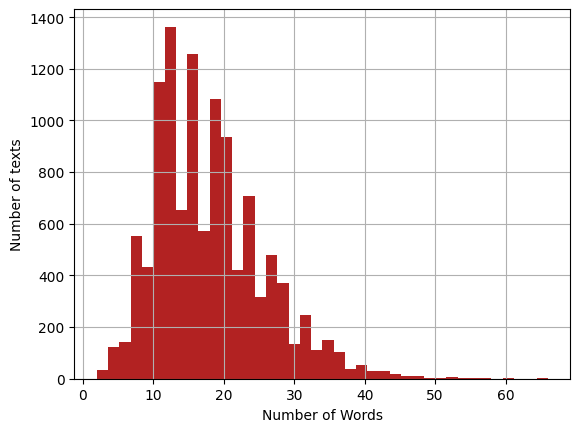

In [ ]:
# Plot histogram of the number of words in train data 'statement'
seq_len = [len(text.split()) for text in train['statement']]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
# "jy46604790/Fake-News-Bert-Detect"
# define the tokenizer
tokenizer = AutoTokenizer.from_pretrained("jy46604790/Fake-News-Bert-Detect")

def tokenize_data(example):
    return tokenizer(example['statement'], padding='max_length', # compress all sentences to maximum of 30 words which is the max_length
                     truncation=True, # cut the sentenced to 30_words
                     max_length=30 # increasing the max length doesn't guarantee a better score
                     )

# Change the tweets to tokens that the models can exploit
dataset = dataset.map(tokenize_data, batched=True)

Map:   0%|          | 0/11552 [00:00<?, ? examples/s]

In [ ]:
# Transform	labels and remove the useless columns or columns that are not tokenized
remove_columns = ['id', 'statement', 'subject', 'speaker', 'job_title', 'state_info', 'party_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context', ]
dataset = dataset.map(remove_columns=remove_columns)

dataset

Map:   0%|          | 0/11552 [00:00<?, ? examples/s]

Map:   0%|          | 0/1284 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 11552
    })
    validation: Dataset({
        features: ['label', 'input_ids', 'attention_mask'],
        num_rows: 1284
    })
})

## Trianing

In [ ]:
# Loading a pretrain model for fine-tuning
model = AutoModelForSequenceClassification.from_pretrained("jy46604790/Fake-News-Bert-Detect")

In [ ]:
# Configure the trianing parameters like `num_train_epochs`:
# the number of time the model will repeat the training loop over the dataset
training_args = TrainingArguments("test_trainer",
                                  num_train_epochs=2, # epoch is ow many times you repeat training
                                  load_best_model_at_end=True,
                                  save_strategy='epoch',
                                  evaluation_strategy='epoch',
                                  logging_strategy='epoch',
                                  per_device_train_batch_size=8, # smaller batches take longer to train
                                  )

In [ ]:
# set up the optimizer with the PyTorch implementation of AdamW
# optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5) # I specified the optimizer to avoid a warning message

In [ ]:
train_dataset = dataset['train'].shuffle(seed=24)
eval_dataset = dataset['validation'].shuffle(seed=24) # scatter the dataset 24 times randomly

In [ ]:
def compute_metrics(eval_pred):      # specify the evaluation metric
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return {
        "rmse": mean_squared_error(labels, predictions, squared=False),
        "classification_report": classification_report(labels, predictions)
    }

In [ ]:
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <cell line: 1>:1                                                                              │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer.py:345 in __init__                  │
│                                                                                                  │
│    342 │   │   │   args = TrainingArguments(output_dir=output_dir)                               │
│    343 │   │   self.args = args                                                                  │
│    344 │   │   # Seed must be set before instantiating the model when using model                │
│ ❱  345 │   │   enable_full_determinism(self.args.seed) if self.args.full_determinism else set_s  │
│    346 │   │   self.hp_name = None                                                               │
│    347 │   │   self.is_in_train = False                                                          │
│    348                                                                                           │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/transformers/trainer_utils.py:93 in set_seed             │
│                                                                                                  │
│    90 │   random.seed(seed)                                                                      │
│    91 │   np.random.seed(seed)                                                                   │
│    92 │   if is_torch_available():                                                               │
│ ❱  93 │   │   torch.manual_seed(seed)                                                            │
│    94 │   │   torch.cuda.manual_seed_all(seed)                                                   │
│    95 │   │   # ^^ safe to call this function even if cuda is not available                      │
│    96 │   if is_tf_available():                                                                  │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/random.py:40 in manual_seed                        │
│                                                                                                  │
│    37 │   import torch.cuda                                                                      │
│    38 │                                                                                          │
│    39 │   if not torch.cuda._is_in_bad_fork():                                                   │
│ ❱  40 │   │   torch.cuda.manual_seed_all(seed)                                                   │
│    41 │                                                                                          │
│    42 │   import torch.mps                                                                       │
│    43 │   if not torch.mps._is_in_bad_fork():                                                    │
│                                                                                                  │
│ /usr/local/lib/python3.10/dist-packages/torch/cuda/random.py:113 in manual_seed_all              │
│                                                                                                  │
│   110 │   │   │   default_generator = torch.cuda.default_generators[i]                           │
│   111 │   │   │   default_generator.manual_seed(seed)                                            │
│   112 │                                                                                          │
│ ❱ 113 │   _lazy_call(cb, seed_all=True)                                                          │
│   114                                                      

In [ ]:
trainer.train()  # rmse 0 to 1 closer to 0 means better performance.

Don't worry the above issue, it is a `KeyboardInterrupt` that means I stopped the training to avoid taking a long time to finish.

In [ ]:
# Launch the final evaluation
trainer.evaluate()  # eval loss is the performance cost of finetuning (0 to 1) 0.5 and above is not suitable.

## Pushing to HuggingFace
Some checkpoints of the model are automatically saved locally in `test_trainer/` during the training.

You may also upload the model on the Hugging Face Platform... [Read more](https://huggingface.co/docs/hub/models-uploading)

In [ ]:
huggingface_hub.notebook_login()
# login to the Hugging Face Hub with your token

In [ ]:
# # Push model and tokenizer to HugginFace
model.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert") # (username/model_name)
tokenizer.push_to_hub("ikoghoemmanuell/finetuned_fake_news_bert")